# distgen Generator - particle generation

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
from distgen import Generator
from astra import Astra, template_dir
from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.plot import marginal_plot
import os

In [3]:
# Get an input file
distgen_in = os.path.join(template_dir, 'dcgun/distgen.yaml')

In [4]:
# Make object, and show its input (calls __repr__)
D = Generator(input=distgen_in, verbose=True)

# Change something
D.input['beam']['particle_count'] = 10000

D

<disgten.Generator with input: 
beam:
  params:
    MTE:
      units: meV
      value: 250
    total_charge:
      units: pC
      value: 100
  particle_count: 10000
  rand_type: hammersley
  start_type: cathode
output:
  file: distgen.part
  type: astra
r_dist:
  params:
    max_r:
      units: mm
      value: 0.5
  type: radial_uniform
t_dist:
  params:
    avg_t:
      units: ps
      value: 0
    sigma_t:
      units: ps
      value: 8.5
  type: gaussian

>

In [5]:
# Make beam, and convert to ParticleGroup
beam = D.beam()
P = ParticleGroup(data=beam.data())
P

Distribution format: astra
Output file: distgen.part

Creating beam distribution....
   Beam starting from: cathode.
   Total charge: 100.000 pC.
   Number of macroparticles: 10000.
   r distribution: radial uniform
      min_r = 0.000 mm, max_r = 0.500 mm
      Assuming cylindrical symmetry...
   t distribution: Gaussian
      avg_t = 0.000 ps, sigma_t = 8.500 ps
   px distribution: Gaussian
      avg_px = 0.000 eV/c, sigma_px = 357.421 eV/c
   py distribution: Gaussian
      avg_py = 0.000 eV/c, sigma_py = 357.421 eV/c
   pz distribution: Gaussian
      avg_pz = 0.000 eV/c, sigma_pz = 357.421 eV/c
   Scaling sigma_x -> 0.250 mm
   Shifting avg_x -> 0.000 m
   Scaling sigma_y -> 0.250 mm
   Shifting avg_y -> 0.000 m
   Scaling sigma_px -> 357.421 eV/c
   Shifting avg_px -> 0.000 eV/c
   Scaling sigma_py -> 357.421 eV/c
   Shifting avg_py -> 0.000 eV/c
   Scaling sigma_pz -> 357.421 eV/c
   Shifting avg_pz -> 0.000 eV/c
   Scaling sigma_t -> 8.500 ps
   Shifting avg_t -> 0.000 ps
   Ca

<ParticleGroup with 10000 particles at 0x11bc63a10>

In [6]:
# Check stats from ParticleGroup's calculation
for x in ['x', 'y', 't', 'px', 'py', 'pz']:
    k = 'sigma_'+x
    print(k, ':', P[k], P.units(k))

sigma_x : 0.00025 m
sigma_y : 0.00025 m
sigma_t : 8.499999999999998e-12 s
sigma_px : 357.42095000287674 eV/c
sigma_py : 357.4209500028768 eV/c
sigma_pz : 215.30781838671672 eV/c


In [7]:
for x in ['x', 'y', 't', 'px', 'py', 'pz']:
    k1 = 'min_'+x
    k2 = 'max_'+x
    print(k1, ':', P[k1], P.units(k1))
    print(k2, ':', P[k2], P.units(k2))

min_x : -0.0004988556955136514 m
max_x : 0.0004995800392784924 m
min_y : -0.0004985365876128583 m
max_y : 0.0004993099847456461 m
min_t : -3.304734752204849e-11 s
max_t : 3.072242239634497e-11 s
min_px : -1369.0534634216929 eV/c
max_px : 1269.8137004496148 eV/c
min_py : -1375.4386232903735 eV/c
max_py : 1249.8411624513408 eV/c
min_pz : 0.04482816140506933 eV/c
max_pz : 1330.3486337311615 eV/c


# Run Astra with Distgen

In [8]:
# Input template file 
ASTRA_IN = os.path.join(template_dir, 'dcgun/astra.in')

In [9]:
# Make an Astra object
A = Astra(input_file=ASTRA_IN, initial_particles=P)

# Change some inputs
A.input['newrun']['zemit']  = 1000
A.input['newrun']['zphase'] = 20
A.input['newrun']['phases'] = True
A.input['newrun']['zstop']  = 1

# Special flag
A.verbose = False

In [10]:
A.run()

# Plot

In [11]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (8,5)

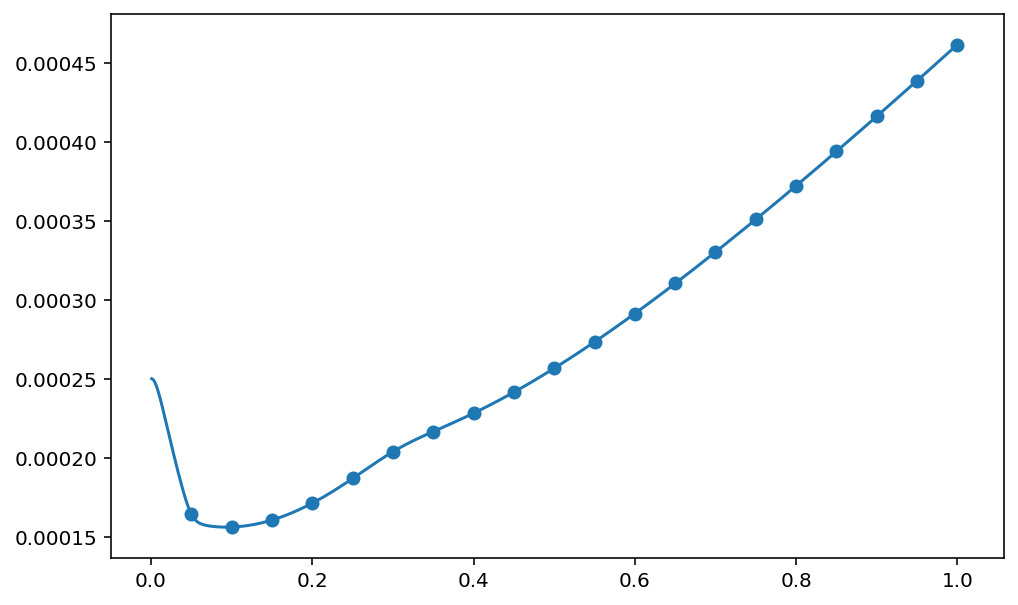

In [12]:
plt.plot(A.stat('mean_z'), A.stat('sigma_x'))
plt.scatter(A.particle_stat('mean_z'), A.particle_stat('sigma_x'))

# Compare with AstraGenerator

In [13]:
from astra import AstraGenerator

In [14]:
GENERATOR_IN = os.path.join(template_dir, 'dcgun/generator.in')
# Make generator object
G = AstraGenerator(input_file=GENERATOR_IN)
G.input['ipart'] = 10000
G.run()
P2 = G.output['particles']

In [15]:
A2 = Astra(input_file=ASTRA_IN, initial_particles=P2)

# Change some inputs
A2.input['newrun']['zemit']  = 1000
A2.input['newrun']['zphase'] = 20
A2.input['newrun']['phases'] = True
A2.input['newrun']['zstop']  = 1
A2.run()

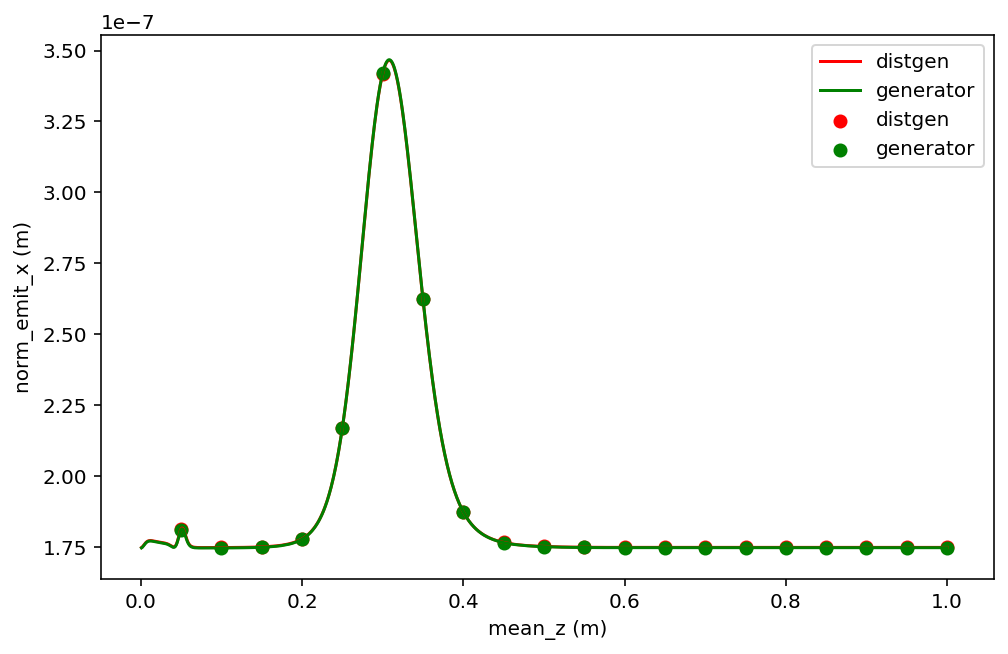

In [16]:

k1 = 'mean_z'
k2 = 'norm_emit_x'

u1 = A.units(k1)
u2 = A.units(k2)
plt.xlabel(k1+f' ({u1})')
plt.ylabel(k2+f' ({u2})')
plt.plot(A.stat(k1), A.stat(k2), color='red', label='distgen')
plt.plot(A2.stat(k1), A2.stat(k2), color='green', label='generator')
plt.scatter(A.particle_stat(k1), A.particle_stat(k2), color='red', label='distgen'),
plt.scatter(A2.particle_stat(k1), A2.particle_stat(k2), color='green', label='generator')
plt.legend()

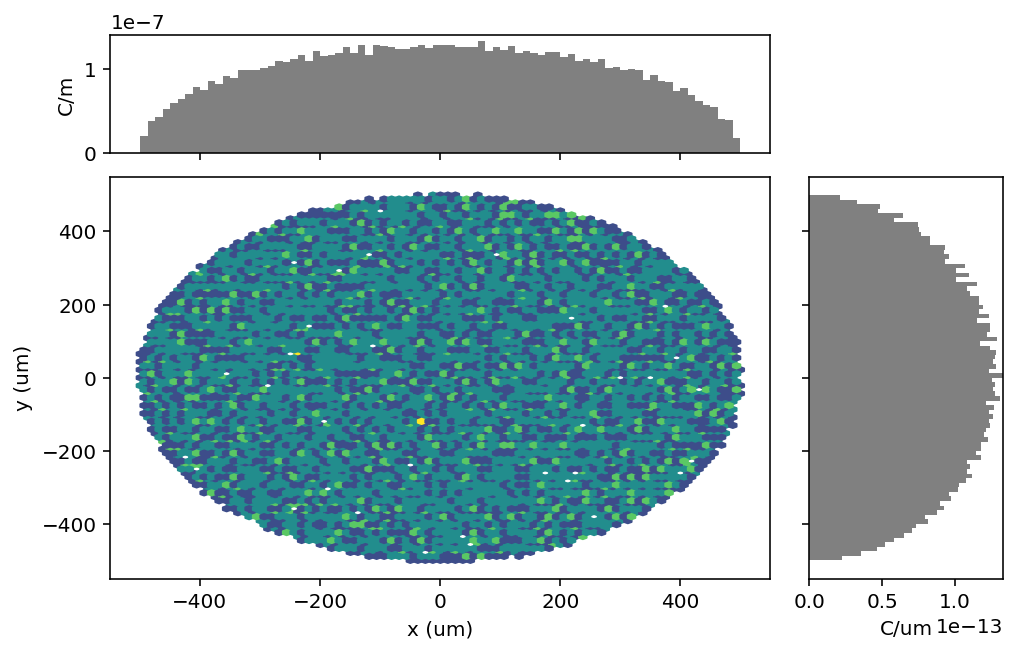

In [17]:
# distgen
marginal_plot(A.initial_particles, 'x', 'y', bins=80)

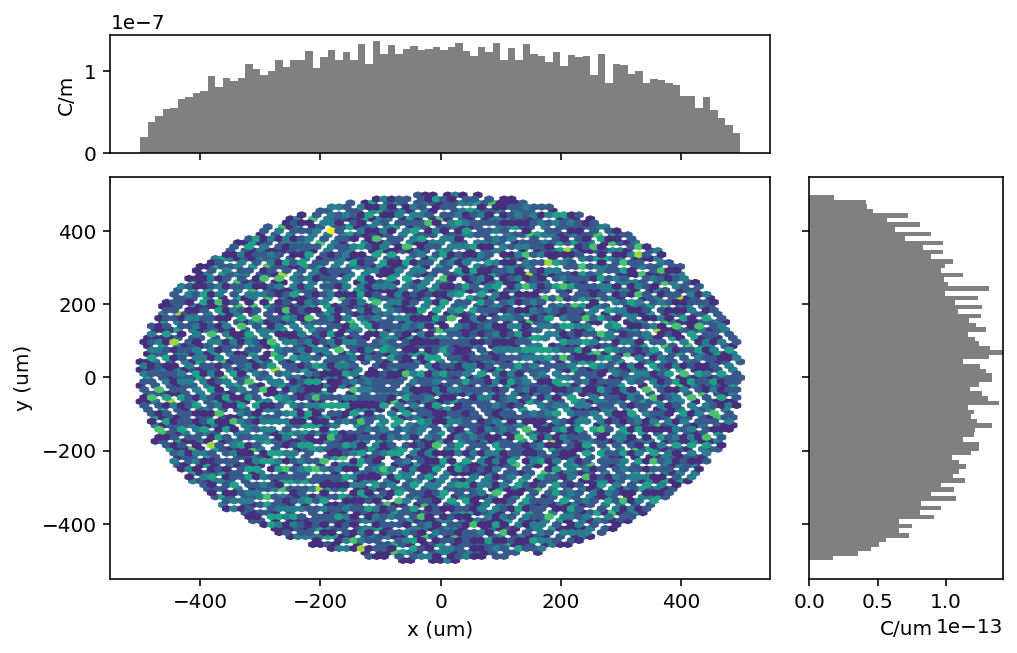

In [18]:
# Generator
marginal_plot(A2.initial_particles, 'x', 'y', bins=80)